# HCC case

In [1]:
from platform import python_version
print(python_version())

3.8.10


In [2]:
import numpy as np
import pandas as pd
import feyn

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from functions import modsum, model_features_chart, crossvalidation_as_framework


In [3]:
feyn.__version__

'2.1.2'

In [4]:
# Load the data
data = pd.read_csv("../data/cancer_hcc.csv")

In [63]:
data.shape

(91, 1713)

In [5]:
# Define the semantic types
stypes = {}
for f in data.columns:
    if data[f].dtype =='object':
        stypes[f] = 'c'
        
# Set random seed for reproducibility
random_seed = 42

# Define the target variable
target = "target"

In [6]:
### get the test data
random_seed = 42
train_val, test = train_test_split(data, test_size=0.2, stratify=data[target], random_state=random_seed)

## Set multifigure filename

In [7]:
filename = '../figures/'

## In depth modelling 

In [8]:
projectname = 'hcc_mctaseq_epigenomics_'

In [9]:
pathname = '../figures/'

In [10]:
### Get the test data
random_seed = 42
train_val, test = train_test_split(data, test_size=0.2, stratify=data[target], random_state=random_seed)

In [11]:
epochs = 50
criterion = 'bic'
max_complexity = 5
random_seed = 15
sw = np.where(train_val[target] == 1, np.sum(train_val[target] == 0)/sum(train_val[target]), 1)

In [12]:
ql = feyn.connect_qlattice(server="https://qlattice.stage.abzu.ai") # Connecting
ql.reset(random_seed) # Resetting
models_single = ql.auto_run(data = train_val,
                         output_name = target,
                         kind = "classification",
                         stypes = stypes,
                         n_epochs = epochs,
                         criterion=criterion,
                         max_complexity = max_complexity,
                         sample_weights=sw)

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="232.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 731 232.0" width="731" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="471" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="361" y="50.0"><title>target
logistic:
w=-32.5610
bias=0.0963</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="71.5">target</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="363" y="59.0">out</text><line stroke="#1E1E1E" x1="331" x2="361" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="50.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="71.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="59.0">1</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="76.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="20.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="41.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="29.0">2</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="28.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="46.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>chr16_67686860_67687674
linear:
scale=0.004219
scale offset=220.611111
w=0.400500
bias=-0.9863</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">chr16_67..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">3</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>chr17_59473060_59483266
linear:
scale=0.001503
scale offset=160.083333
w=-6.810673
bias=0.1618</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">chr17_59..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="80.0"><title>chr6_87832219_87832610
linear:
scale=0.006006
scale offset=179.472222
w=1.298637
bias=0.3125</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="101.5">chr6_878..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="89.0">5</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="123" y="89.0">num</text></svg><svg class="summary" height="79" width="180" x="471" y=
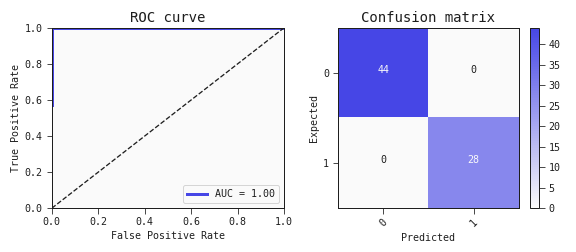
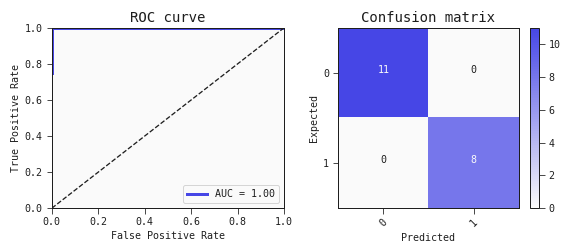

In [13]:
models_single[0].plot(train_val,test)

In [14]:
df_summary = modsum(models_single, train_val, test)[['N. Features', 'Functional form', 'BIC', 'Loss', 'AUC Train']]
df_summary

,N. Features,Functional form,BIC,Loss,AUC Train
0,3,logreg(chr166768686067687674 + chr175947306059...,11.67,0.021642,1.0
1,3,logreg(chr10131761169131771696*chr175947306059...,13.56,0.005101,1.0
2,3,logreg(chr168964105389643415 + chr175947306059...,13.62,0.035156,1.0
3,3,logreg(chr10131761169131771696*chr175947306059...,14.19,0.009462,1.0
4,3,logreg(chr111775605617758286 + chr175947306059...,14.68,0.042525,1.0
5,2,logreg(chr175947306059483266 + chr399878959989...,14.72,0.072524,1.0
6,3,logreg(chr10131761169131771696 + chr1759473060...,14.75,0.043011,1.0
7,2,logreg(chr175947306059483266 + chr687832219878...,17.81,0.094013,0.99
8,3,logreg(chr175947306059483266 + chr311952892011...,19.82,0.078207,1.0
9,3,logreg(chr175947306059483266 + chr194957512949...,19.88,0.078681,1.0


In [64]:
for m in df_summary['Functional form']:
    print(m)

logreg(chr166768686067687674 + chr175947306059483266 + chr68783221987832610)
logreg(chr10131761169131771696*chr175947306059483266 + chrX3754480437545419)
logreg(chr168964105389643415 + chr175947306059483266 + chr6158507719158508126)
logreg(chr10131761169131771696*chr175947306059483266 + chr11069829910698910)
logreg(chr111775605617758286 + chr175947306059483266 + chr518819241887743)
logreg(chr175947306059483266 + chr399878959989619)
logreg(chr10131761169131771696 + chr175947306059483266 + chr72324555623246161)
logreg(chr175947306059483266 + chr68783221987832610)
logreg(chr175947306059483266 + chr3119528920119529159 + chr399878959989619)
logreg(chr175947306059483266 + chr194957512949576076 + chr6158507719158508126)


In [15]:
feature_plot_hcc_mctaseq = model_features_chart(test, models_single, metric="roc_auc_score")
model_features_chart(test, models_single, metric="roc_auc_score")

,roc_auc_score,chr17_59473060_59483266,chr10_131761169_131771696,chr3_9987895_9989619,chr6_158507719_158508126,chr6_87832219_87832610,chr3_119528920_119529159,chr5_1881924_1887743,chr7_23245556_23246161,chr19_49575129_49576076,chrX_37544804_37545419,chr16_67686860_67687674,chr16_89641053_89643415,chr11_17756056_17758286,chr1_10698299_10698910
Model#,,,,,,,,,,,,,,,
0,1.000000,True,False,False,False,True,False,False,False,False,False,True,False,False,False
1,1.000000,True,True,False,False,False,False,False,False,False,True,False,False,False,False
2,0.965909,True,False,False,True,False,False,False,False,False,False,False,True,False,False
3,0.988636,True,True,False,False,False,False,False,False,False,False,False,False,False,True
4,0.909091,True,False,False,False,False,False,True,False,False,False,False,False,True,False
5,1.000000,True,False,True,False,False,False,False,False,False,False,False,False,False,False
6,0.988636,True,True,False,False,False,False,False,True,False,False,False,False,False,False
7,0.943182,True,False,False,False,True,False,False,False,False,False,False,False,False,False
8,1.000000,True,False,True,False,False,True,False,False,False,False,False,False,False,False


In [16]:
#feature_plot_hcc_mctaseq.to_excel('HCC_QLattice_feature_plot_hcc_mctaseq_autorun_251121.xlsx')

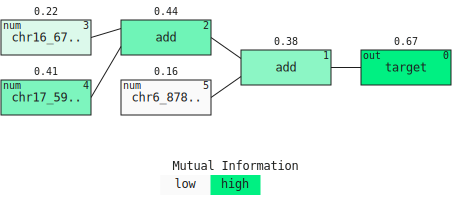

In [17]:
models_single[0].plot_signal(train_val, corr_func='mutual_information')

In [18]:
sympy_model = models_single[0].sympify(symbolic_lr = True, signif=3)
sympy_model.as_expr()

1/(6.59e-10*exp(0.055*chr166768686067687674 - 0.333*chr175947306059483266 + 0.254*chr68783221987832610) + 1)

In [19]:
features_data = train_val[models_single[0].features + ["target"]]

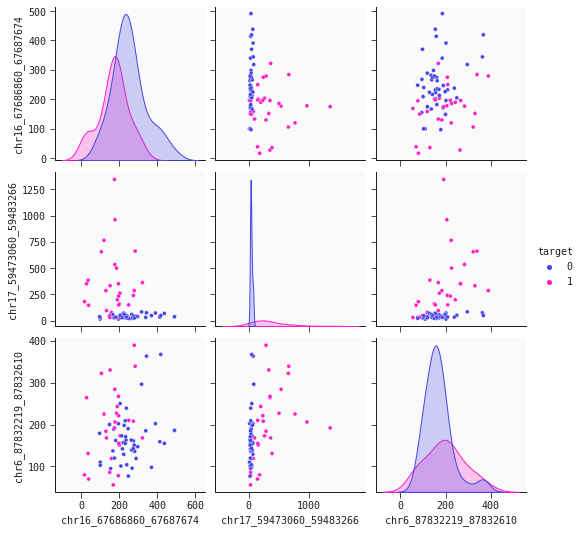

In [42]:
import seaborn as sns
# Pairplot with target coloring
sns.pairplot(features_data, hue = 'target')

In [23]:
features_data.columns

Index(['chr16_67686860_67687674', 'chr17_59473060_59483266',
       'chr6_87832219_87832610', 'target'],
      dtype='object')

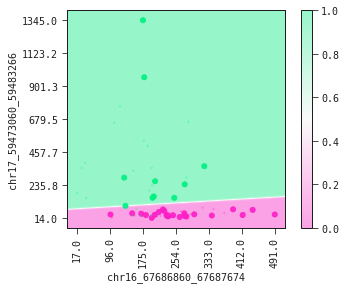

In [27]:
# Plot a 2-dimensional partial plot
models_single[0].plot_response_2d(features_data, fixed={'chr6_87832219_87832610':train_val.chr6_87832219_87832610.mean()})

#### max_complexity = 3

In [66]:
ql = feyn.connect_qlattice(server="https://qlattice.stage.abzu.ai") # Connecting
ql.reset(random_seed) # Resetting
models_single3 = ql.auto_run(data = train_val,
                         output_name = target,
                         kind = "classification",
                         stypes = stypes,
                         n_epochs = epochs,
                         criterion=criterion,
                         max_complexity = 3,
                         sample_weights=sw)

In [68]:
df_summary3 = modsum(models_single3, train_val, test)[['N. Features', 'Functional form', 'BIC', 'Loss', 'AUC Train']]
df_summary3

,N. Features,Functional form,BIC,Loss,AUC Train
0,2,logreg(chr10131761169131771696*chr175947306059...,13.7,0.035745,1.0
1,2,logreg(chr175947306059483266*chr613110681314220),15.48,0.048121,1.0
2,2,logreg(chr175947306059483266 + chr687832219878...,16.61,0.085679,0.99
3,2,logreg(chr111775605617758286 + chr175947306059...,20.14,0.110174,0.99
4,2,logreg(chr175635637456357013 + chr175947306059...,20.38,0.111796,0.99
5,2,logreg(chr175947306059483266 + chr819492451951...,21.13,0.117029,0.99
6,2,logreg(chr6158507719158508126*chr8145103285145...,21.44,0.089457,1.0
7,2,logreg(chr175947306059483266 + chr723245556232...,22.44,0.126122,0.99
8,2,logreg(chr111775605617758286*chr17594730605948...,22.48,0.096698,1.0
9,2,logreg(chr111775605617758286*chr81451032851451...,22.52,0.096975,1.0


<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="216.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 621 216.0" width="621" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="351" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="241" y="50.0"><title>target
logistic:
w=-11.0827
bias=3.3175</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="71.5">target</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="243" y="59.0">out</text><line stroke="#1E1E1E" x1="211" x2="241" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="50.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="71.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="59.0">1</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="76.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>chr17_59473060_59483266
linear:
scale=0.001503
scale offset=160.083333
w=5.445550
bias=0.5950</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">chr17_59..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>chr10_131761169_131771696
linear:
scale=0.012579
scale offset=60.236111
w=-8.165687
bias=-4.9890</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">chr10_13..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">3</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text></svg><svg class="summary" height="79" width="180" x="351" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="0" y="14">Training Metrics</text><line stroke="#1E1E1E" x1="0" x2="160" y1="19" y2="19" /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="34">Accuracy</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="34">0.986</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="49">AUC</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="49">1.0</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="64">Precision</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="64">0.966</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="79">Recall</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="79">1.0</text></svg><svg class="summary" height="79" width="90" x="531" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-si
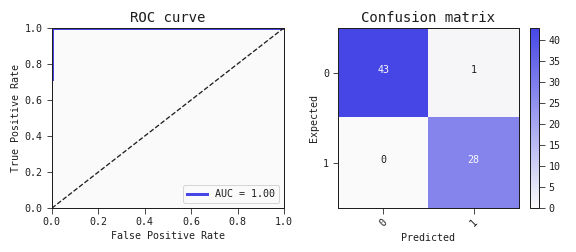
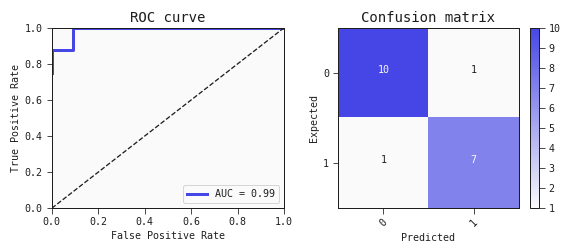

In [70]:
models_single3[0].plot(train_val, test)

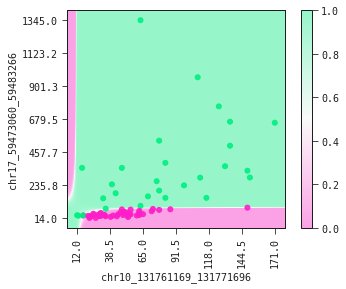

In [73]:
# Plot a 2-dimensional partial plot
models_single3[0].plot_response_2d(train_val)

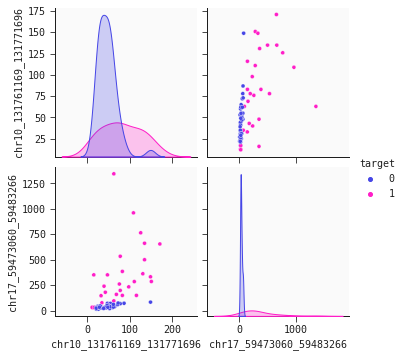

In [74]:
sns.pairplot(train_val[models_single3[0].features + ["target"]], hue = 'target')

# Cross-validation as a framework

In [61]:
max_complexity

5

In [49]:
results = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = epochs,
                                     criterion=criterion,
                                     max_complexity = max_complexity)

In [50]:
# average performance of first 10 models
results.roc_auc_val.mean(), results.accuracy_val.mean()

(0.9167857142857144, 0.8688888888888888)

In [51]:
# average performance of first model
results.groupby("fold").first().roc_auc_val.mean(), results.groupby("fold").first().accuracy_val.mean()

(0.922077922077922, 0.8894736842105264)

In [52]:
results.groupby("fold").first()

,model_structure,aic,bic,roc_auc_train,accuracy_train,roc_auc_val,accuracy_val,pr_auc,f1,query_string
fold,,,,,,,,,,
0,logreg(chr175947306059483266 + chr224901891749...,8.185402,12.738734,1.000000,1.000000,1.000000,0.947368,1.000000,0.727273,"add(add(""chr2_8816314_8817264"", ""chr22_4901891..."
1,logreg(chr175947306059483266 + chr399878959989...,7.746731,12.327650,1.000000,1.000000,1.000000,0.944444,1.000000,0.636364,"add(add(""chr3_9987895_9989619"", ""chr5_18004578..."
2,logreg(chr10131761169131771696 + chr1131573931...,10.531609,15.112528,0.999216,0.986301,1.000000,1.000000,1.000000,0.608696,"add(add(""chr11_315739_316539"", ""chr10_13176116..."
3,logreg(chr126613512066136400 + chr175947306059...,4.112028,6.402488,1.000000,1.000000,0.844156,0.777778,0.763652,0.560000,"add(""chr12_66135120_66136400"", ""chr17_59473060..."
4,logreg(chr224665839746659332*chr59292348792924...,4.012732,8.593651,1.000000,1.000000,0.766234,0.777778,0.773313,0.560000,"multiply(""chr5_92923487_92924497"", ""chr22_4665..."


In [59]:
for m in results.groupby('fold').first().model_structure:
    print(m)

logreg(chr175947306059483266 + chr224901891749019317 + chr288163148817264)
logreg(chr175947306059483266 + chr399878959989619 + chr5180045789180048897)
logreg(chr10131761169131771696 + chr11315739316539 + chr175947306059483266)
logreg(chr126613512066136400 + chr175947306059483266)
logreg(chr224665839746659332*chr59292348792924497)


In [53]:
results3 = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = epochs,
                                     criterion=criterion,
                                     max_complexity = 3)

In [54]:
results3.groupby("fold").first().roc_auc_val.mean(), results3.groupby("fold").first().accuracy_val.mean()

(0.9662337662337661, 0.9555555555555557)

In [62]:
results3.groupby("fold").first().roc_auc_val.std()

0.05479226781747789

In [55]:
results3.groupby("fold").first()

,model_structure,aic,bic,roc_auc_train,accuracy_train,roc_auc_val,accuracy_val,pr_auc,f1,query_string
fold,,,,,,,,,,
0,logreg(chr175947306059483266 + chr399878959989...,13.492817,15.769483,0.995942,0.972222,1.000000,1.000000,1.000000,0.800000,"add(""chr17_59473060_59483266"", ""chr3_9987895_9..."
1,logreg(chr175947306059483266 + chr399878959989...,13.773893,16.064352,0.996865,0.972603,1.000000,1.000000,1.000000,0.777778,"add(""chr17_59473060_59483266"", ""chr3_9987895_9..."
2,logreg(chr175947306059483266 + chr399878959989...,11.457714,13.748173,0.998433,0.958904,0.987013,0.944444,0.980867,0.636364,"add(""chr17_59473060_59483266"", ""chr3_9987895_9..."
3,logreg(chr175947306059483266 + chr399878959989...,6.935219,9.225678,1.000000,0.986301,0.974026,0.944444,0.966270,0.608696,"add(""chr3_9987895_9989619"", ""chr17_59473060_59..."
4,logreg(chr1112524468112525385 + chr17594730605...,3.775859,6.066319,1.000000,1.000000,0.870130,0.888889,0.894855,0.608696,"add(""chr17_59473060_59483266"", ""chr1_112524468..."


In [60]:
for m in results3.groupby('fold').first().model_structure:
    print(m)

logreg(chr175947306059483266 + chr399878959989619)
logreg(chr175947306059483266 + chr399878959989619)
logreg(chr175947306059483266 + chr399878959989619)
logreg(chr175947306059483266 + chr399878959989619)
logreg(chr1112524468112525385 + chr175947306059483266)


# Correlation plot for article

In [47]:
best = models_single[1]

In [48]:
best.features

['chr19_13207375_13207621', 'chr3_9987895_9989619']

In [49]:
import seaborn as sns

In [50]:
# Take a random subset of 100 features
data_wo_target = data.drop('target', axis = 1)
sampled_features = np.unique(list(np.random.choice(data_wo_target.columns, 100, replace=False)) + best.features)
sample_data = data[sampled_features]

In [51]:
# Prepare for labelling the two model features in the heatmap
label_feature = list()

for x, i in enumerate(sampled_features):
    if i in best.features:
        label_feature.append(1)
    else: label_feature.append(0)

# Assign colors to chosen features
lut = dict({0: 'w',
           1: 'b'})

# Map colors to correlation data
row_coloring = pd.Series(label_feature, index = sample_data.corr().index).map(lut)

/home/niels/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


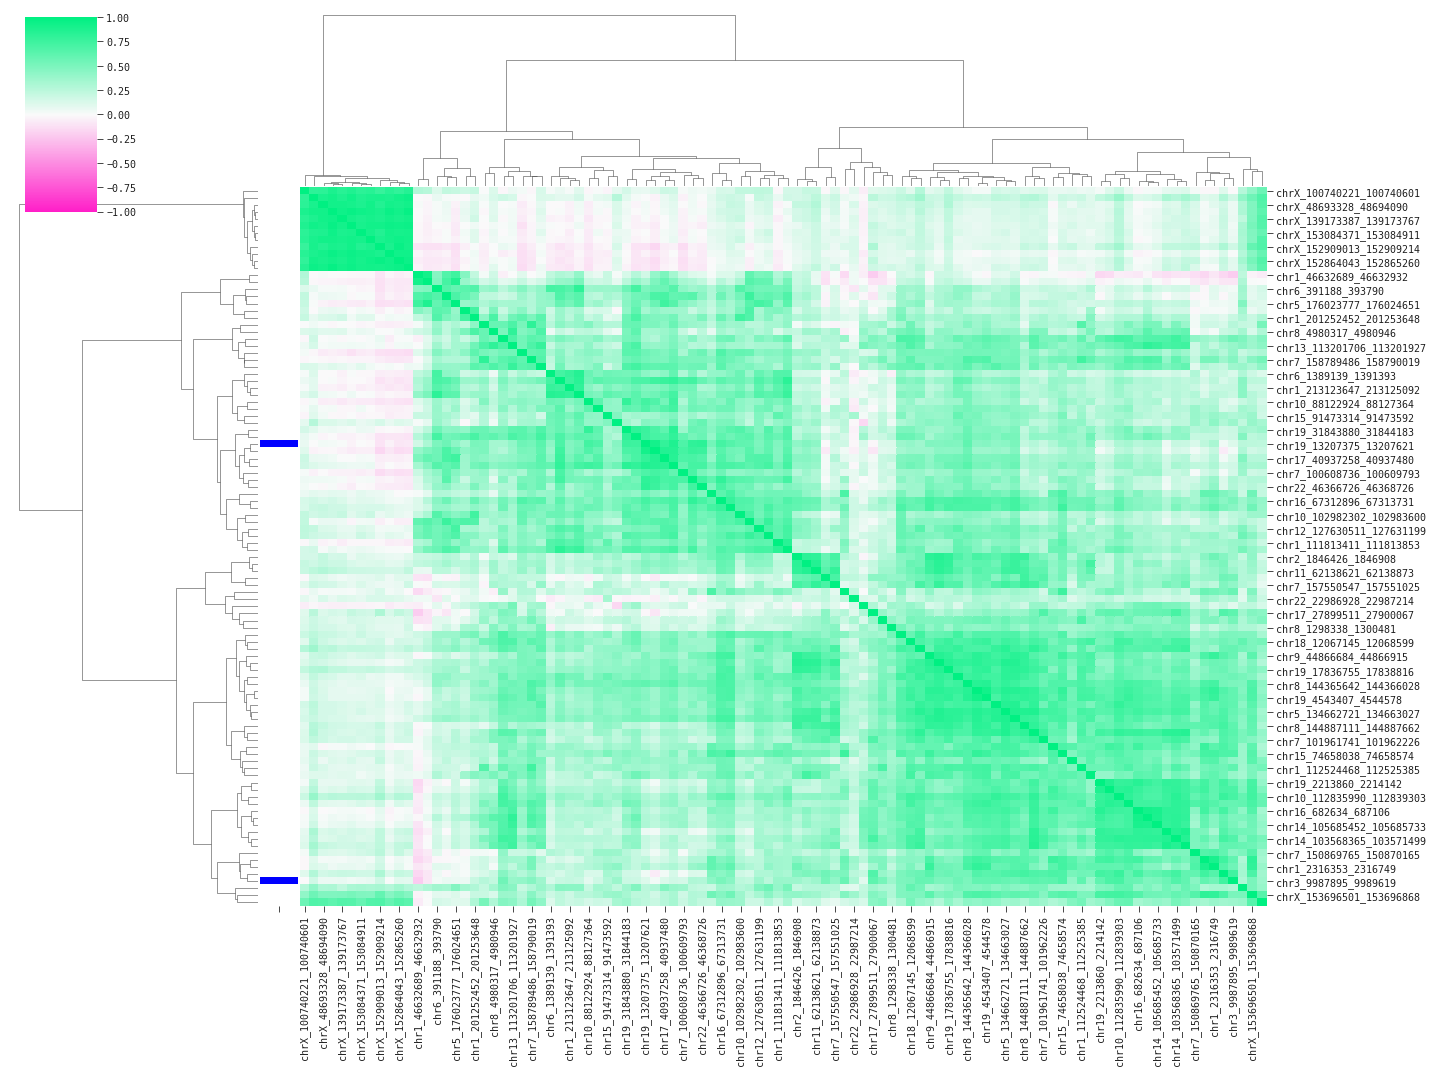

In [52]:
p = sns.clustermap(sample_data.corr(), method="ward", cmap='feyn-diverging', row_colors = row_coloring,
               vmin=-1, vmax=1, figsize=(20,15), robust=False)

In [53]:
p.savefig("HCC_seaborn_corrmap_031121.png")

In [54]:
pwd

'/home/niels/manuscript_abzu/manuscript_AD_HCC_notebooks/notebooks'

# Additional plots for article

In [55]:
sympy_model = best.sympify(symbolic_lr = True, signif=3)
sympy_model.as_expr()

1/(0.0436*exp(-0.969*chr191320737513207621 + 0.12*chr399878959989619) + 1)